<a href="https://colab.research.google.com/github/soberbichler/Workshop_QualitativeDataResearch_LLM/blob/main/SummerSchool_Fine_Tuning_Llama_HF_Job.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Adapter-Based Tuning for Argument Mining
##Llama 3.1 8B Instruct Model for the Extraction of Argumentative Units in Historical Newspapers

Adapter-based tuning, inlike fine-tuning, modifies only a small subset of model parameters by inserting lightweight modules between layers while keeping original weights frozen. Methods like LoRA add low-rank matrices to approximate fine-tuning, requiring updates to just 1 % of parameters in large models. This approach reduces computational costs and enables multi-task efficiency—one base model can host multiple task-specific adapters, eliminating the need for separate full models for different tasks like translation or summarization.

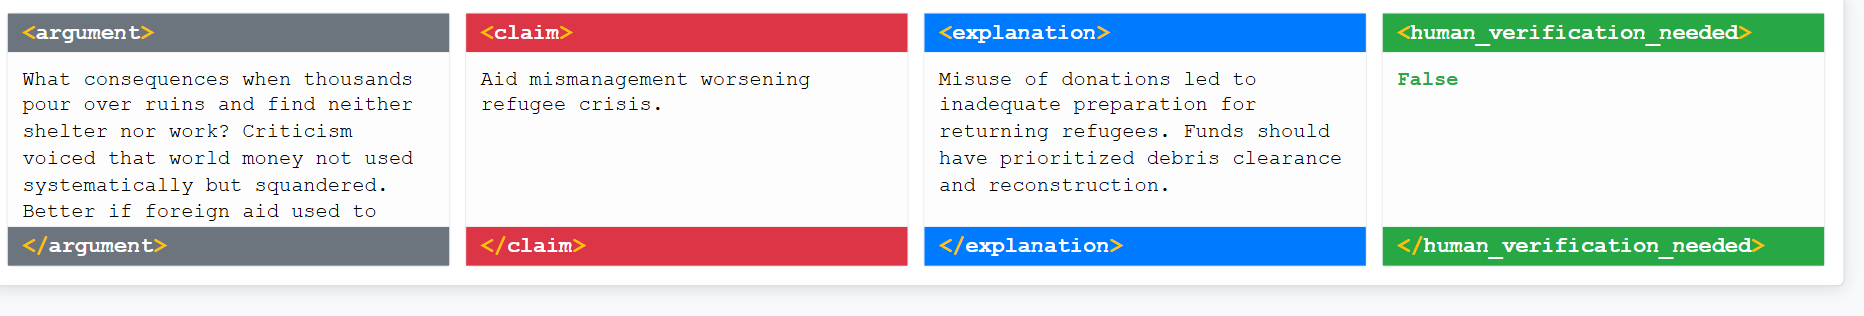

In [ ]:
#Install and import required packages
!pip install pandas openpyxl scikit-learn ftfy

import pandas as pd
import json
import re
from sklearn.model_selection import train_test_split
import os
import ftfy  # Fixes text encoding issues
import random
from collections import Counter

## First, we need to prepare our dataset to create Llama training examples

Preparing a dataset for Llama training involves several crucial steps to transform raw data into the specific format that Llama models expect. The process begins with collecting and cleaning your source data, removing any unwanted artifacts, duplicates, or formatting inconsistencies that could negatively impact training quality. Next, the data must be tokenized using Llama's specific tokenizer to ensure compatibility with the model's vocabulary and token limits. Each training example typically needs to be structured with appropriate prompt templates, often including system prompts, user inputs, and assistant responses clearly delineated with special tokens like <|begin_of_text|>, <|start_header_id|>, and <|eot_id|>. For fine-tuning tasks, the dataset should be formatted as instruction-response pairs or conversation chains, with careful attention paid to maintaining consistent formatting throughout. Additionally, it's important to split the data into training and validation sets, ensure proper text encoding (UTF-8), and consider implementing data augmentation strategies if your dataset is limited in size. The final prepared dataset should be saved in a format compatible with your training framework, such as JSON, JSONL, or Hugging Face's dataset format, ready to be loaded efficiently during the training process.

In [ ]:
# 1: Load your Excel file with proper encoding
file_path = "/content/argument_mining.xlsx"
print(f"Loading data from: {file_path}")

df = pd.read_excel(file_path, engine='openpyxl')
print(f"Loaded {len(df)} rows")
print(f"Columns: {list(df.columns)}")
df

In [ ]:
# 2: Clean text but preserve XML
def clean_preserve_xml(text):
    if pd.isna(text) or text == "":
        return ""
    text = str(text).strip()
    if text.startswith('"<argument>') and text.endswith('</argument>"'):
        text = text[1:-1]
    text = re.sub(r'<article>\s*', '<article>', text)
    text = re.sub(r'\s*</article>', '</article>', text)
    text = re.sub(r'<argument>\s*', '<argument>', text)
    text = re.sub(r'\s*</argument>', '</argument>', text)
    text = re.sub(r'[ \t]+', ' ', text)
    text = re.sub(r'\n{3,}', '\n\n', text)
    return text.strip()

In [ ]:
# Cell 4: Create Llama training examples
def create_llama_example(article_text, created_text):
    # YOUR FULL SYSTEM PROMPT
    system_prompt = """You are an expert at analyzing German historical texts.

OUTPUT FORMAT - EXACTLY these 4 XML tags and NOTHING else:
<argument>Main argument text OR "NA"</argument>
<claim>Core claim in one sentence OR "NA"</claim>
<explanation>Why this is an argument OR "NA"</explanation>
<human_verification_needed>True OR False</human_verification_needed>

EXAMPLE WITH ARGUMENT:
<argument>Es sind furchtbare Bilder, die sich dabei entrollen. Unter den Trümmern des einen Hause», so erzählt Luigt Barsint im Corrtcre della sera, findet man die Leichen von Unglück lichen, die in anderen Häusern gewohnt baben und die in der Ber- Wirrung de» schrcck.ichen Augenblickes instinktiv bet Fremden Hülfe und Unterschlupf suchten. Niemand erkennt jetzt diese armen Ein dringlinge, ihre Leichen werden nicht reklamiert, und man trägt sie hinunter an de» Strand, wo sie in langer Reihe einer neben den anderen hingebettet weiden, in denselben Tüchern und Decken, in denen sie tbren Tod gesunden.</argument>
<claim>The earthquake's chaos led to unidentified victims dying in unfamiliar places.</claim>
<explanation>Describes how people fled to other houses seeking help during the disaster, died there, and now cannot be identified or claimed by relatives. Shows cause (panic/confusion) and effect (anonymous deaths).</explanation>
<human_verification_needed>False</human_verification_needed>

EXAMPLE WITHOUT ARGUMENT:
<argument>NA</argument>
<claim>NA</claim>
<explanation>NA</explanation>
<human_verification_needed>False</human_verification_needed>

RULES:
- NO SUMMARY; ONLY ORIGINAL EXTRACTOM FROM THE TEXT; don't extract anything that is not in the text. Only extract word by word
- ONLY output these 4 XML tags
- Extract only original text from the article without changes and extract enough context.
- Factual descriptions are no arguments
- The claim is not a translation of summary of argument. It should say what the (implicite) argument implies
- Extract full passages/units of argument (more than one sentence)
- If no argument exists, use NA for all fields except human verification
- More than one argumentative unit possible for one aticle, one unit has one clear clame and all the xml structures"""

    # YOUR user instruction
    user_instruction = (
        "Extract argumentative units in its original form. ONLY. NO SUMMARY; ONLY ORIGINAL EXTRACTOM FROM THE TEXT; don't extract anything that is not in the text. Only extract word by word\n"
        "Text to analyze:\n"
        f"{article_text}"
    )

    # Clean and validate the response
    response = created_text.strip() if created_text else "NA"

    # ENSURE proper NA format
    if response.lower() in ["no arguments", "na", ""]:
        response = """<argument>NA</argument>
<claim>NA</claim>
<explanation>NA</explanation>
<human_verification_needed>NA</human_verification_needed>"""


    # Remove any accidental prompt inclusions
    if "<|begin_of_text|>" in response or "<|start_header_id|>" in response:
        # Extract only the XML part
        import re
        xml_match = re.search(r'(<argument>.*?</human_verification_needed>)', response, re.DOTALL)
        if xml_match:
            response = xml_match.group(1)

    # Build the training example
    llama_text = (
        f"<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n"
        f"{system_prompt}<|eot_id|>"
        f"<|start_header_id|>user<|end_header_id|>\n"
        f"{user_instruction}<|eot_id|>"
        f"<|start_header_id|>assistant<|end_header_id|>\n"
        f"{response}<|eot_id|><|end_of_text|>"  # Added end token
    )

    return {
        "text": llama_text,
        "instruction": user_instruction,
        "response": response,
        "has_argument": not ("NA</argument>" in response)
    }

In [ ]:
# 6: Process all rows
print("Processing all data...")
article_col = "extracted_articles"
created_col = "llm_training_answer"
training_examples = []
skipped = 0

for idx, row in df.iterrows():
    article = clean_preserve_xml(row[article_col])
    created_text = clean_preserve_xml(row.get(created_col, ""))

    if not article or len(article) < 100:
        skipped += 1
        continue

    example = create_llama_example(article, created_text)
    example['source_row'] = idx
    training_examples.append(example)

    if (idx + 1) % 50 == 0:
        print(f"Processed {idx + 1}/{len(df)} rows...")

print(f"\nProcessing complete!")
print(f"Created {len(training_examples)} training examples")
print(f"Skipped {skipped} rows (too short or empty)")

In [ ]:
# 8: Save training data
output_file = "llama_training_data_balanced.jsonl"
with open(output_file, 'w', encoding='utf-8') as f:
    for example in training_examples:
        save_example = {k: v for k, v in example.items() if k != 'has_argument'}
        f.write(json.dumps(save_example, ensure_ascii=False) + '\n')

print(f"\nSaved {len(training_examples)} balanced examples to: {output_file}")
file_size = os.path.getsize(output_file)
print(f"File size: {file_size:,} bytes ({file_size/1024/1024:.1f} MB)")

In [ ]:
# 9: Optional train/validation split
if len(training_examples) > 20:
    train_data, val_data = train_test_split(
        training_examples,
        test_size=0.2,
        random_state=42,
        stratify=[ex['has_argument'] for ex in training_examples]
    )

    train_file = "llama_train_balanced.jsonl"
    val_file = "llama_validation_balanced.jsonl"

    for fpath, dataset in [(train_file, train_data), (val_file, val_data)]:
        with open(fpath, 'w', encoding='utf-8') as f:
            for example in dataset:
                save_example = {k: v for k, v in example.items() if k != 'has_argument'}
                f.write(json.dumps(save_example, ensure_ascii=False) + '\n')

    print(f"Saved training data: {train_file} ({len(train_data)} examples)")
    print(f"Saved validation data: {val_file} ({len(val_data)} examples)")
else:
    train_file = output_file

print("\n✅ Data preparation complete! Ready for training.")

#Ready for Training

In [ ]:
# 1: Check your files
import os
import json

files_to_check = ['llama_train_balanced.jsonl', 'llama_validation_balanced.jsonl']
for file in files_to_check:
    if os.path.exists(file):
        with open(file, 'r') as f:
            lines = f.readlines()
            print(f"✓ {file}: {len(lines)} examples, {os.path.getsize(file):,} bytes")
            # Show first example
            first = json.loads(lines[0])
            print(f"  First example preview: {first['text'][:100]}...")
    else:
        print(f"✗ {file} not found!")

In [ ]:
# 2: Install HF hub
!pip install -U huggingface_hub

In [ ]:
# 3: Set your HF username and dataset repo
import os
os.environ['HF_USERNAME'] = 'oberbics'
os.environ['HF_DATASET_REPO'] = 'oberbics/jobs'
print(f"Username: {os.environ['HF_USERNAME']}")
print(f"Dataset repo: {os.environ['HF_DATASET_REPO']}")

In [ ]:
# 4: Login to Hugging Face
# You'll need your HF token from https://huggingface.co/settings/tokens
!huggingface-cli login

## Create Training Script

This script is designed for adapter-based tuning of Meta's Llama 3.1 8B Instruct model for argumentative unit extraction. The script loads training data from JSON files containing text examples, then adapts the large language model to extract units in a structured format (argument, claim, explanation and verification for expert-in-the-loop control).

The technical implementation uses several memory optimization techniques to handle the 8B parameter model efficiently. It employs 4-bit quantization through BitsAndBytesConfig to reduce memory usage, implements LoRA (Low-Rank Adaptation) for parameter-efficient fine-tuning, and uses gradient checkpointing along with CPU/disk offloading to manage GPU memory constraints. The script is configured to work with limited hardware by using techniques like mixed precision training (fp16) and paged AdamW optimizer, making it feasible to train on systems with memory limitations while still working with the full Llama 3.1 model.

The training configuration includes several anti-overfitting measures (it is more important to force the model into the xml structure than learning from the examples) that were specifically updated in this version of the script. It reduces the LoRA rank from 16 to 8, increases dropout from 0.1 to 0.2, decreases the learning rate to 5e-5, and limits training to 2 epochs instead of 3. Additional regularization techniques include weight decay (L2 regularization) and label smoothing to prevent the model from becoming overconfident. The script also includes validation monitoring if a validation dataset is available, and implements comprehensive logging and checkpointing to track training progress and save the model at regular intervals.



> ***Add your name to the model title everywhere where it says "your_name"***

You can search "your_name" and then add your name there




> ***Adapt Training Arguments and LoRA Configurations to improve training.***

Check online what the args and configurations stand for.





> ***Fill in your Model Documentation Sheet while waiting***




In [ ]:
# 1: Create Llama-3.1 training script with improved parameters
llama_31_training_script_v2 = """
import os
import torch
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    Trainer,
    TrainingArguments,
    DataCollatorForLanguageModeling
)
from datasets import load_dataset
from peft import LoraConfig, get_peft_model, TaskType, prepare_model_for_kbit_training
from huggingface_hub import login
import gc

# --- Environment Fix for CUDA Fragmentation ---
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Setup
token = os.environ.get('HF_TOKEN')
print(f"Token: {token[:10]}...")
login(token=token)

# Load dataset
print("Loading dataset...")
train_dataset = load_dataset('json', data_files='train_balanced.jsonl', split='train')
print(f"✓ Loaded {len(train_dataset)} training examples")

# Check for validation set
try:
    val_dataset = load_dataset('json', data_files='validation_balanced.jsonl', split='train')
    print(f"✓ Loaded {len(val_dataset)} validation examples")
    has_validation = True
except:
    print("ℹNo validation set found, training without validation")
    val_dataset = None
    has_validation = False

# Clear GPU memory before loading model
torch.cuda.empty_cache()
gc.collect()

# Model setup - USING META-LLAMA-3.1
model_id = "meta-llama/Llama-3.1-8B-Instruct"
print(f"\\nLoading {model_id} with CPU/GPU offloading...")

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True
)

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map="auto",
    offload_folder="./offload",
    offload_state_dict=True,
    token=token,
    trust_remote_code=True,
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True
)

# Prepare model for k-bit training
model = prepare_model_for_kbit_training(model)

# Enable gradient checkpointing
model.gradient_checkpointing_enable()
model.enable_input_require_grads()

tokenizer = AutoTokenizer.from_pretrained(model_id, token=token)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

# ===== LoRA CONFIGURATION  =====
peft_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
    lora_dropout=0.2,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, peft_config)
print("\\nTrainable parameters:")
model.print_trainable_parameters()

# Tokenization with longer context for discourse analysis
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=5048
    )

print("\\nTokenizing dataset...")
tokenized_dataset = train_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=train_dataset.column_names
    )

if has_validation:
    tokenized_val_dataset = val_dataset.map(
        tokenize_function,
        batched=True,
        remove_columns=val_dataset.column_names
    )


#===== TRAINING ARGUMENTS =====
training_args = TrainingArguments(
    output_dir="./llama-3.1-newspater-argument-your_name",
    num_train_epochs=2,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,
    gradient_checkpointing=True,
    warmup_steps=30,
    learning_rate=5e-5,
    fp16=True,
    logging_steps=5,
    save_steps=50,
    save_total_limit=2,


    # Evaluation settings (if validation set exists)
    eval_strategy="steps" if has_validation else "no",
    eval_steps=50 if has_validation else None,
    load_best_model_at_end=True if has_validation else False,
    metric_for_best_model="loss" if has_validation else None,
    greater_is_better=False if has_validation else None,

    # Hub settings
    push_to_hub=True,
    hub_model_id="oberbics/llama-3.1-newspaper-arguments-your_name",
    hub_token=token,
    report_to=[],

    # Optimizer settings
    optim="paged_adamw_8bit",
    max_grad_norm=0.3,
    warmup_ratio=0.03,

    # Additional regularization
    weight_decay=0.01,
    label_smoothing_factor=0.0,
)

# Calculate total steps
total_steps = (len(tokenized_dataset) // training_args.gradient_accumulation_steps) * training_args.num_train_epochs
print(f"\\nTraining details:")
print(f"  - Model: {model_id}")
print(f"  - Dataset: {len(tokenized_dataset)} training examples")
if has_validation:
    print(f"  - Validation: {len(tokenized_val_dataset)} examples")
print(f"  - Epochs: {training_args.num_train_epochs}")
print(f"  - Total steps: ~{total_steps}")
print(f"  - Learning rate: {training_args.learning_rate}")
print(f"  - LoRA rank: {peft_config.r}")
print(f"  - LoRA dropout: {peft_config.lora_dropout}")
print(f"  - GPU: A100-80GB (with CPU/disk offloading)")

# Trainer with validation if available
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    eval_dataset=tokenized_val_dataset if has_validation else None,
    data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False),
    # Custom callback to monitor overfitting
    callbacks=[]  # You could add EarlyStoppingCallback here if needed
)

# Train
print("\\n" + "="*50)
print("Starting Llama-3.1 training for discourse analysis...")
print("Model will learn to identify arguments AND generate explanations")
print("="*50)

try:
    # Train the model
    trainer.train()

    # Log final metrics
    if has_validation:
        eval_results = trainer.evaluate()
        print(f"\\nFinal validation loss: {eval_results.get('eval_loss', 'N/A')}")

    print("\\nSaving model...")
    trainer.save_model()
    trainer.push_to_hub()
    tokenizer.push_to_hub("oberbics/llama-3.1-newspaper-arguments-your_name", token=token)

    # Save training info
    with open("training_info.txt", "w") as f:
        f.write(f"Model: {model_id}\\n")
        f.write(f"Training examples: {len(tokenized_dataset)}\\n")
        f.write(f"Epochs: {training_args.num_train_epochs}\\n")
        f.write(f"Learning rate: {training_args.learning_rate}\\n")
        f.write(f"LoRA rank: {peft_config.r}\\n")
        f.write(f"LoRA dropout: {peft_config.lora_dropout}\\n")
        f.write(f"Final training loss: Check logs\\n")
        if has_validation:
            f.write(f"Final validation loss: {eval_results.get('eval_loss', 'N/A')}\\n")

    print("\\n" + "="*50)
    print("TRAINING COMPLETE!")
    print(f"Model: https://huggingface.co/oberbics/llama-3.1-newspaper-argument-your_name")
    print("Check training_info.txt for metrics")
    print("="*50)

except Exception as e:
    print(f"\\nError during training: {e}")
    print("Attempting to save checkpoint...")
    try:
        trainer.save_model("./emergency_checkpoint")
        print("✓ Emergency checkpoint saved")
    except:
        print("Could not save checkpoint")
"""

with open("llama_31_training_v2.py", "w") as f:
    f.write(llama_31_training_script_v2)
print("Created llama_31_training_v2.py with anti-overfitting parameters")


In [ ]:
# 2: Upload and launch Llama training
from huggingface_hub import HfApi, HfFolder
api = HfApi()

# Upload training script
api.upload_file(
    path_or_fileobj="llama_31_training_v2.py",
    path_in_repo="german-argument-mining/llama_31_training_v2.py",
    repo_id="oberbics/jobs",
    repo_type="dataset"
)

# Upload training data files too
api.upload_file(
    path_or_fileobj="llama_train_balanced.jsonl",
    path_in_repo="german-argument-mining/train_balanced.jsonl",
    repo_id="oberbics/jobs",
    repo_type="dataset"
)

# Get token
token = HfFolder.get_token()

print("Launching Llama training...")
# Use f-string to properly interpolate the token
!hf jobs run --flavor a100-large \
  pytorch/pytorch:2.1.0-cuda12.1-cudnn8-devel \
  /bin/bash -c " \
    echo 'Starting Llama Training' && \
    export HF_TOKEN='{token}' && \
    apt-get update -qq && apt-get install -y -qq wget && \
    pip install -q torch transformers peft datasets bitsandbytes accelerate huggingface_hub && \
    wget -q https://huggingface.co/datasets/oberbics/jobs/resolve/main/german-argument-mining/train_balanced.jsonl && \
    wget -q https://huggingface.co/datasets/oberbics/jobs/resolve/main/german-argument-mining/llama_31_training_v2.py && \
    wget https://huggingface.co/datasets/oberbics/jobs/resolve/main/german-argument-mining/validation_balanced.jsonl && \
    python llama_31_training_v2.py \
  "

## Merge LoRA adapter with Llama base model




> ***Add your HF token to "secrets" (little key) with the name HF_TOKEN and the token under values***


In [ ]:
# 1: Install and setup
!pip install -q huggingface_hub transformers peft accelerate

from huggingface_hub import login
from google.colab import userdata
import os

# Login to Hugging Face
token = userdata.get("HF_TOKEN")  # or paste manually instead of userdata
os.environ["HF_TOKEN"] = token
login(token=token)
print("Logged in to Hugging Face")


This script performs model merging to combine the fine-tuned LoRA adapter with the original Llama 3.1 base model, creating a standalone full model. After the previous training script created a LoRA adapter (which only stores the small additional weights learned during fine-tuning), this merge script loads both the original Meta-Llama-3.1-8B-Instruct model and the trained adapter, then combines them into a single complete model that contains all the newspaper argument analysis capabilities without requiring the PEFT library.

The process involves loading the base model, applying the LoRA adapter weights to it, and then "merging and unloading" to create a standard transformer model with all weights integrated. The merged model is then uploaded to Hugging Face Hub as "llama-3.1-newspaper-arguments-your_name," making it easier to use since it no longer needs separate adapter loading. This merged version can be used directly like any standard language model, while retaining all the specialized training for newspaper discourse analysis that was learned during the fine-tuning process.

In [ ]:
# 2: Merge script for Meta-Llama-3.1 Newspaper Arguments
merge_script = """
import os, warnings
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel
from huggingface_hub import login, HfApi

warnings.filterwarnings("ignore")

# Setup
token = os.environ.get("HF_TOKEN")
print(f"Token prefix: {token[:10]}...")
login(token=token)

print("="*50)
print("Starting Model Merge: Llama 3.1 Newspaper Arguments")
print("="*50)

# IDs
base_model_id = "meta-llama/Llama-3.1-8B-Instruct"
adapter_id   = "oberbics/llama-3.1-newspaper-arguments-your_name"
repo_id      = "oberbics/llama-3.1-newspaper-arguments-your_name-full"

# Load base model
print(f"\\n Loading base model: {base_model_id}")
base = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    torch_dtype=torch.float16,
    device_map="auto",
    token=token,
    trust_remote_code=True,
    low_cpu_mem_usage=True
)
print("✓ Base model loaded")

#  Load adapter
print(f"\\n Loading adapter: {adapter_id}")
model_with_adapter = PeftModel.from_pretrained(
    base,
    adapter_id,
    token=token,
    device_map="auto"
)
print("✓ Adapter loaded")

#  Merge
print("\\n Merging models...")
merged_model = model_with_adapter.merge_and_unload()
print("✓ Merge complete")

#  Tokenizer
print("\\n Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(adapter_id, token=token)
print("✓ Tokenizer loaded")

# Upload
print("\\n Uploading to Hub (this may take 5–10 minutes)...")
try:
    merged_model.push_to_hub(
        repo_id,
        token=token,
        safe_serialization=True,
        max_shard_size="5GB"
    )
    tokenizer.push_to_hub(repo_id, token=token)
    print("✓ Model + tokenizer uploaded")
except Exception as e:
    print(f" Direct push failed: {e}")
    print("Trying folder upload...")
    merged_model.save_pretrained("./merged", safe_serialization=True, max_shard_size="5GB")
    tokenizer.save_pretrained("./merged")
    HfApi().upload_folder(folder_path="./merged", repo_id=repo_id, token=token)
    print("✓ Uploaded via folder method")

print("\\n" + "="*50)
print("SUCCESS!")
print(f"Full model available at: https://huggingface.co/{repo_id}")
print("="*50)
"""

with open("merge_llama3.1_newspaper.py", "w") as f:
    f.write(merge_script)

print("Created merge_llama31_newspaper.py")


In [ ]:
# 3: Upload the script to your jobs repo
api = HfApi()
api.upload_file(
    path_or_fileobj="merge_llama3.1_newspaper.py",
    path_in_repo="merge_jobs/merge_llama3.1_newspaper.py",
    repo_id="oberbics/jobs",  # your jobs repo
    repo_type="dataset",
    token=token
)
print("Merge script uploaded")


In [ ]:
# 4: Launch the job on Hugging Face with GPU
import subprocess

command = f"""
hf jobs run --flavor a100-large \\
  pytorch/pytorch:2.6.0-cuda12.4-cudnn9-devel \\
  /bin/bash -c \\
  "apt-get update && apt-get install -y git && \\
   pip install -q --upgrade pip && \\
   pip install -q torch transformers peft accelerate huggingface_hub && \\
   git clone https://huggingface.co/datasets/oberbics/jobs jobs_repo && \\
   cd jobs_repo && \\
   export HF_TOKEN={token} && \\
   python merge_jobs/merge_llama3.1_newspaper.py"
"""

print("Launching merge job...")
result = subprocess.run(command, shell=True, capture_output=True, text=True)
print(result.stdout)
print(result.stderr)
